In [1]:
import logging
logging.disable(logging.INFO)

In [ ]:
# We download an extract of Kuzak Dempsy's dataset that also can be found here:
# https://raw.githubusercontent.com/vserret/datasets/main/heart_data.csv
!wget https://raw.githubusercontent.com/vserret/datasets/main/heart_data.csv

Connection 
....

In [2]:
import pyqrlew as pq
qdb = pq.from_csv(
    table_name="heart_data", 
    csv_file="https://raw.githubusercontent.com/vserret/datasets/main/heart_data.csv"
)

In [3]:
ds = qdb.dataset()
ds.relations()

[(['heart_data'], <Relation at 0x10fa71f30>)]

In [4]:
import pandas as pd
pd.DataFrame(qdb.execute("SELECT * FROM heart_data")).head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


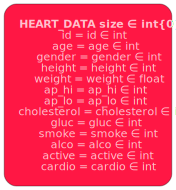

In [5]:
import graphviz

def display_dot(dot_graph): 
    display(graphviz.Source(dot_graph))

display_dot(ds.relations()[0][1].dot())

The min and max values for bmi: [15.359168241965973, 38.19297095019482]
The propagated datatype is: {bmi: float[13.149243918474689 39.06249999999999]}


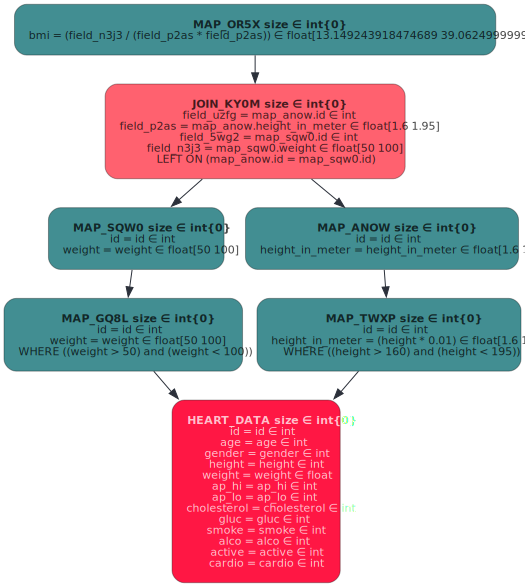

In [6]:
# BMI = weight(kg) / height_m ** 2
query = """
WITH 
    height_table AS (SELECT id, height_in_meter AS height_in_meter FROM (SELECT id, height * 0.01 AS height_in_meter FROM heart_data WHERE height > 160 AND height < 195) AS subq),
    weight_table AS (SELECT id, weight AS weight FROM (SELECT id, weight FROM heart_data WHERE weight > 50 AND weight < 100) AS subq)
SELECT weight / (height_in_meter * height_in_meter) AS bmi FROM height_table LEFT JOIN weight_table ON height_table.id = weight_table.id
"""
relation = ds.sql(query)

df0 = pd.DataFrame(qdb.eval(relation))
print(f"The min and max values for bmi: [{df0['bmi'].min()}, {df0['bmi'].max()}]")
print(f"The propagated datatype is: {relation.schema()}")    

display_dot(relation.dot())

The min and max values for creff: [57.6, 88.2]
The propagated datatype is: {creff: float[56.7 90]}


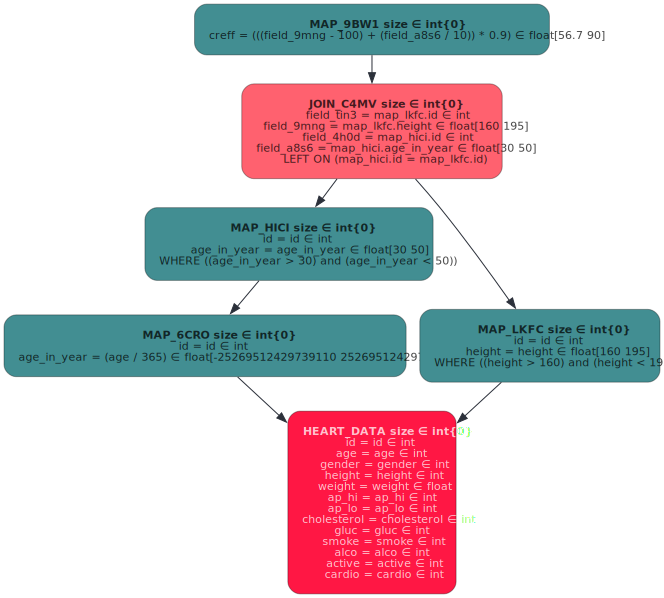

In [7]:
# creff [height(cm) - 100 + age(year) / 10] * 0,9

query = """
WITH 
    height_table AS (SELECT id, height FROM heart_data WHERE height > 160 AND height < 195),
    age_table AS (SELECT id, age_in_year FROM (SELECT id, (age / 365) AS age_in_year FROM heart_data) AS subq WHERE age_in_year > 30 AND age_in_year < 50)
SELECT (height - 100 + age_in_year / 10) * 0.9 AS creff FROM height_table LEFT JOIN age_table ON age_table.id = height_table.id
"""
relation = ds.sql(query)

df0 = pd.DataFrame(qdb.eval(relation))
print(f"The min and max values for creff: [{df0['creff'].min()}, {df0['creff'].max()}]")
print(f"The propagated datatype is: {relation.schema()}")

display_dot(relation.dot())

The min and max values for lorentz: [56.6, 76.4]
The propagated datatype is: {lorentz: float[42 92.5]}


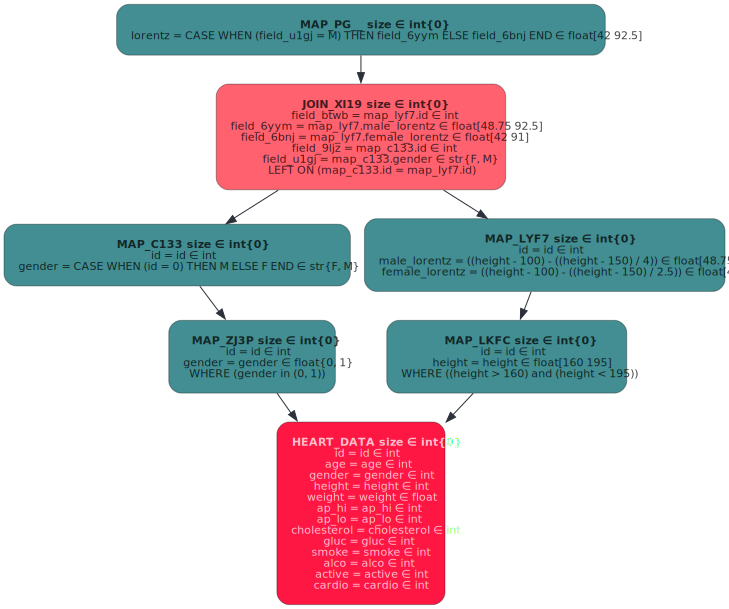

In [8]:
#Lorentz formula
#if gender='M', height(cm) - 100 - ((height(cm) - 150) / 4)
#if gender='F', height(cm) - 100 - ((height(cm) - 150) / 2,5).

query = """
WITH 
    height_table AS (SELECT id, height FROM heart_data WHERE height > 160 AND height < 195),
    lorentz_table AS (SELECT id, (height - 100 - (height - 150) / 4) AS male_lorentz, (height - 100 - (height - 150)/2.5) AS female_lorentz FROM height_table),
    gender_table AS (SELECT id, CASE WHEN id = 0 THEN 'M' ELSE 'F' END AS gender FROM (SELECT id, gender AS gender FROM heart_data WHERE gender in (0, 1)) AS subq)
SELECT CASE WHEN gender = 'M' THEN male_lorentz ELSE female_lorentz END AS lorentz FROM lorentz_table LEFT JOIN gender_table ON gender_table.id = lorentz_table.id
"""
relation = ds.sql(query)

df0 = pd.DataFrame(qdb.eval(relation))
print(f"The min and max values for lorentz: [{df0['lorentz'].min()}, {df0['lorentz'].max()}]")
print(f"The propagated datatype is: {relation.schema()}")  

display_dot(relation.dot())

The min and max values for lorentz: [56.599999999999994, 76.39999999999999]
The propagated datatype is: {lorentz: float[56 83.75]}


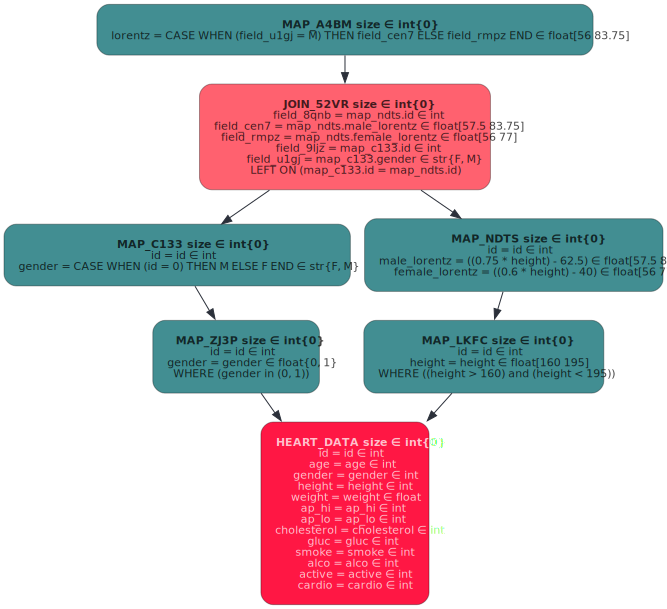

In [9]:
#Lorentz formula
#if gender='M', height(cm) - 62.5
#if gender='F', 0.6 * height(cm) -40.0

query = """
WITH 
    height_table AS (SELECT id, height FROM heart_data WHERE height > 160 AND height < 195),
    lorentz_table AS (SELECT id, 0.75 * height - 62.5 AS male_lorentz, (0.6 * height -40.0) AS female_lorentz FROM height_table),
    gender_table AS (SELECT id, CASE WHEN id = 0 THEN 'M' ELSE 'F' END AS gender FROM (SELECT id, gender AS gender FROM heart_data WHERE gender in (0, 1)) AS subq)
SELECT CASE WHEN gender = 'M' THEN male_lorentz ELSE female_lorentz END AS lorentz FROM lorentz_table LEFT JOIN gender_table ON gender_table.id = lorentz_table.id
"""
relation = ds.sql(query)

df0 = pd.DataFrame(qdb.eval(relation))
print(f"The min and max values for lorentz: [{df0['lorentz'].min()}, {df0['lorentz'].max()}]")
print(f"The propagated datatype is: {relation.schema()}")  

display_dot(relation.dot())